## Part II
# Binomial Tree: option valuation (50 pts.)
 
 A commonly used approach to compute the price of an option is the so-called binomial tree method. Suppose that the maturity of an option on a non-dividend-paying stock St is divided into N subintervals of length ∆t. We will refer to the j th node at time i · ∆t as the (i, j) node. The stock price at the (i, j) node is Si,j = S0u^j * d^(i-j) (with u and d the upward and downward stock price movements, respectively). In the binomial tree approach, option prices are computed through a backward induction scheme:

1. The value of a call option at its expiration date is max{$0, S_{N,j} − K$};
2. Suppose that the values of the option at time (i + 1) · ∆t is known for all j. There is a risk-neutral probability p of moving from the (i, j) node at time i · ∆t to the (i + 1, j + 1) node at time (i + 1) · ∆t , and a probability 1 − p of moving from the (i, j) node at time i · ∆t to the (i + 1, j) node at time (i + 1) · ∆t . Risk-neutral valuation gives $f_{i,j} = e^{-r\Delta t} \left( p f_{i+1,j+1} + (1 - p) f_{i+1,j} \right)$

A general introduction to the binomial tree model and a detailed derivation of the relevant parameters is provided in appendix A. Please read the appendix carefully before starting on the assignment.

Consider a European call option on a non-dividend-paying stock with a maturity of one year and strike price of €99. Let the one year interest rate be 6% and the current price of the stock be €100. Furthermore, assume that the volatility is 20%.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [58]:
def buildTree(S, vol, T, N):
    dt = T / N

    matrix = np.zeros((N + 1, N + 1))

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    
    for i in np.arange(N + 1):
        for j in np.arange(i + 1):
            matrix[i, j] = S * (u ** j) * (d ** (i - j))
            
    return matrix

In [59]:
sigma = 0.1
S = 80
T = 1
N = 2
buildTree(S, sigma, T, N)

array([[80.        ,  0.        ,  0.        ],
       [74.53851387, 85.86165282,  0.        ],
       [69.44987563, 80.        , 92.15279281]])

In [60]:
def valueOptionMatrix(tree, vol, T, N, r, K):
    tree = tree.copy()
    
    dt = T / N

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))

    p = (np.exp(r * dt) - d) / (u - d)

    columns = tree.shape[1]
    rows = tree.shape[0]
    
    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c] # value in the matrix
        tree[rows - 1, c] = max(S - K, 0) # payoff function
    
    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            # print(f"r: {r}, dt: {dt}, p: {p}, down: {down}, up: {up}")
            tree[i, j] = np.exp(-r * dt) * (p * up + (1 - p) * down)
            
    return tree

In [61]:
sigma = 0.1
S = 80
T = 1
N = 2

K = 85
r = 0.1

tree = buildTree(S, sigma, T, N)
valueOptionMatrix(tree, sigma, T, N, r, K)

array([[4.61654023, 0.        , 0.        ],
       [0.        , 5.74640373, 0.        ],
       [0.        , 0.        , 7.15279281]])

## Question 1

In [62]:
sigma = 0.2
S = 100
T = 1
N = 50

K = 99
r = 0.06

tree = buildTree(S, sigma, T, N)
option_matrix = valueOptionMatrix(tree, sigma, T, N, r, K)
option_price_binom = option_matrix[0, 0]

print(f"Option price: €{option_price_binom:.2f}")

Option price: €11.55


# Question 2

In [63]:
def option_price_analytical(S, T, r, K, sigma):
    # Black-Scholes formula for European option prices
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

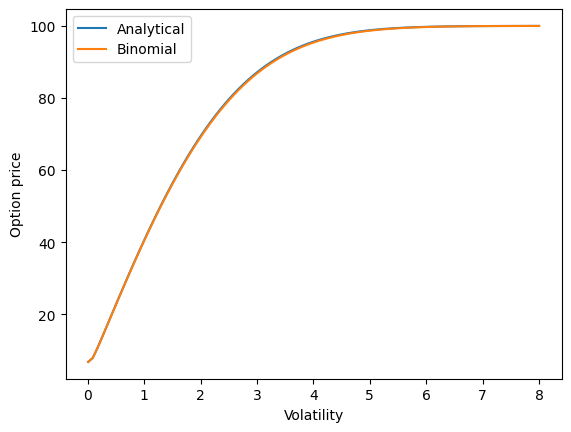

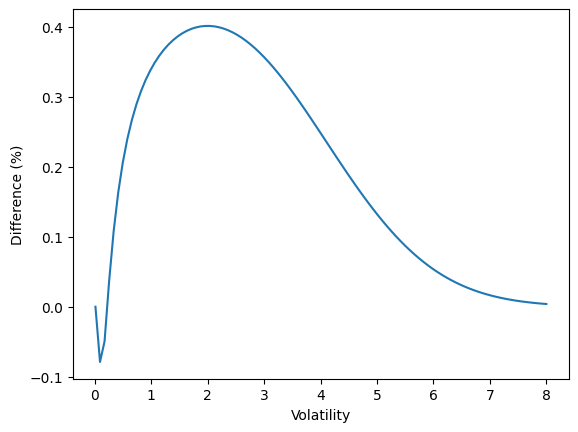

In [80]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 8, 100)

analytical_pricings = []
binomial_pricings = []

for sigma in sigma_values:
    option_price_analyt = option_price_analytical(S, T, r, K, sigma)
    tree = buildTree(S, sigma, T, N)
    option_matrix = valueOptionMatrix(tree, sigma, T, N, r, K)
    option_price_binom = option_matrix[0, 0]

    analytical_pricings.append(option_price_analyt)
    binomial_pricings.append(option_price_binom)

# Plot the results
plt.plot(sigma_values, analytical_pricings, label="Analytical")
plt.plot(sigma_values, binomial_pricings, label="Binomial")
plt.xlabel("Volatility")    
plt.ylabel("Option price")
plt.legend()
plt.show()

# Procentual difference
diff = (np.array(analytical_pricings) - np.array(binomial_pricings)) / np.array(analytical_pricings) * 100
plt.plot(sigma_values, diff)
plt.xlabel("Volatility")
plt.ylabel("Difference (%)")
plt.show()

## Question 3

100%|██████████| 299/299 [00:08<00:00, 35.47it/s] 


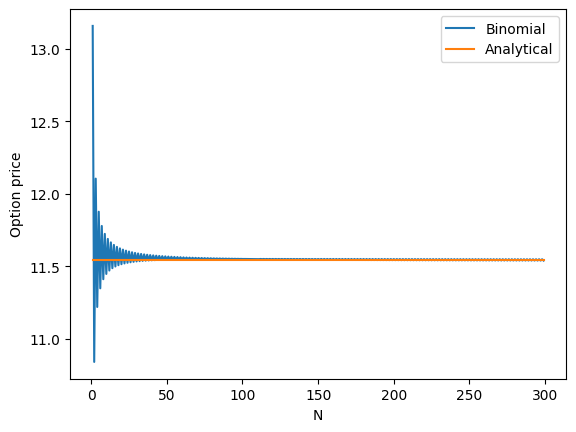

In [65]:
sigma = 0.2
S = 100
T = 1

K = 99
r = 0.06

# Play around with different ranges of N and step sizes.
N = np.arange(1, 300)

# Calculate the option price for the correct parameters
optionPriceAnalytical = option_price_analytical(S, T, r, K, sigma)

# Calculate option price for each n in N
optionPricesBinomial = []
for n in tqdm(N):
    treeN = buildTree(S, sigma, T, n)
    priceApproximatedly = valueOptionMatrix(treeN, sigma, T, n, r, K)[0, 0]
    optionPricesBinomial.append(priceApproximatedly)

# use matplotlib to plot the analytical value
# and the approximated value for each n
plt.plot(N, optionPricesBinomial, label="Binomial")
plt.plot(N, [optionPriceAnalytical] * len(N), label="Analytical")
plt.xlabel("N")
plt.ylabel("Option price")
plt.legend()
plt.show()

## Question 4

In [66]:
def delta_black_scholes(S, T, r, K, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

In [67]:
def delta_binomial(S, T, r, K, sigma, N):
    tree = buildTree(S, sigma, T, N)
    option_tree = valueOptionMatrix(tree, sigma, T, N, r, K)
    delta = (option_tree[1, 1] - option_tree[1, 0]) / (tree[1, 1] - tree[1, 0])
    return delta

In [69]:
# Test on small example
sigma = 0.1
S = 80
T = 1
N = 2

K = 85
r = 0.1

tree = buildTree(S, sigma, T, N)
print(f"Tree:\n {tree}\n")
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K)
print(f"Option Tree:\n {option_tree}\n")

delta_bs = delta_black_scholes(S, T, r, K, sigma)
delta_bin = delta_binomial(S, T, r, K, sigma, N)

print(f"Delta Black-Scholes: {delta_bs:.2f}")
print(f"Delta Binomial: {delta_bin:.2f}")

Tree:
 [[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]

Option Tree:
 [[4.61654023 0.         0.        ]
 [0.         5.74640373 0.        ]
 [0.         0.         7.15279281]]

Delta Black-Scholes: 0.67
Delta Binomial: 0.51


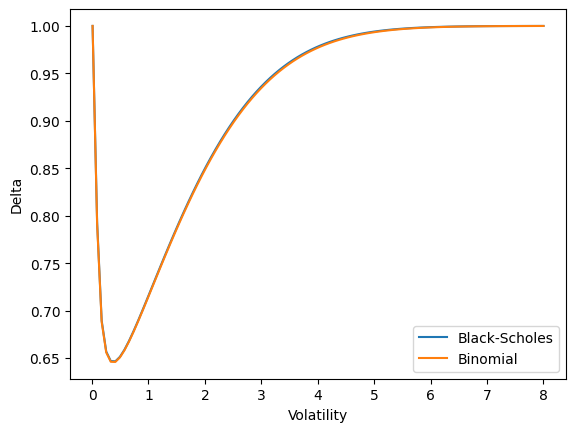

In [81]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 8, 100)

delta_bs_values = []
delta_bin_values = []

for sigma in sigma_values:
    delta_bs = delta_black_scholes(S, T, r, K, sigma)
    delta_bin = delta_binomial(S, T, r, K, sigma, N)

    delta_bs_values.append(delta_bs)
    delta_bin_values.append(delta_bin)

# Plot the results
plt.plot(sigma_values, delta_bs_values, label="Black-Scholes")
plt.plot(sigma_values, delta_bin_values, label="Binomial")
plt.xlabel("Volatility")
plt.ylabel("Delta")
plt.legend()
plt.show()

## Question 5

In [ ]:
# Function for american option pricing
def valueOptionMatrixAmerican(tree, vol, T, N, r, K):
    pass